#QUINCY HERSHEY - ALEX MOORE - ADAM DICHIARA - SCOTT TANG - VINCENT FILARDI
#CS541 Project: MAML CNN
---


In [1]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
colab=True
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Project/data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## RESISC45

---

In [2]:
np.random.seed(1)
random.seed(1)
test_size = 0.8
val_size = 0.2
batch_size = 32
MAML_learning_rate1 = 0.0006
MAML_learning_rate2 = 0.0006
CNN_learning_rate = 0.0006
MAML2_learning_rate1=.00045
MAML2_learning_rate2=25e-05
n_epochs = 150
print_stride = 10
Freeze=False
First_Train = True
no_load = True
bce_loss = nn.BCELoss()

In [3]:
class CustomTensorDataset(Dataset):

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform=transform

    def __getitem__(self, index):
        X = self.images[index]
        y = self.labels[index]
        return X, y

    def __len__(self):
        return len(self.images)

def make_dataset(x, y):
    x = torch.tensor(x).permute(0,3,1,2)
    y = torch.tensor(y)
    dset = CustomTensorDataset(x, y)
    return dset

In [4]:
def get_data(dir, mtype):
    if mtype=='MAML': batch_n = batch_size*2
    else: batch_n = batch_size

    data = np.load(dir+'RESISC45_images_96.npy')
    labels = np.load(dir+'RESISC45_classes.npy')
    classes = np.load(dir+'RESISC45_class_names.npy')

    #img_size = train_data.shape[2]
    c_dim = classes.shape[0]

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size, stratify = labels)

    xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size = val_size)

    trainset = make_dataset(xtrain,ytrain)
    train_loader = DataLoader(trainset, batch_size=int(batch_n), shuffle=True)

    valset = make_dataset(xval, yval)
    val_loader = torch.utils.data.DataLoader(valset, batch_n, drop_last = True, shuffle=True)

    testset = make_dataset(test_data, test_labels)
    test_loader = torch.utils.data.DataLoader(testset, batch_n, drop_last = True, shuffle=True)

    return train_loader, val_loader, test_loader, c_dim, classes

In [5]:
class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # Input: (batch_size, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(1024)
        
        self.fce = nn.Linear(1024, 45)


    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        x = x/127.5 - 1.0
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))

        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))

        return z

    def save(self, name):
        print('saving...')
        torch.save({
            'model_state_dict': self.state_dict() #,
            #'optimizer_state_dict': self.optimizer.state_dict(),
        }, dir+name+'.pt')

    def load(self, name):
        print('loading...')
        checkpoint = torch.load(dir+name+'.pt')
        self.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def get_model(mtype, lr=0.0006, train=True,load=False):
    model = Conv_Pred().to(device)
    model.weight_init()
    if load==True:
        try: model.load(mtype)
        except: pass
    if train == True:
        model.train()
    else:
        model.eval()
    return model


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)

def one_hot_embedding(labels, dims):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = dims)
    return torch.squeeze(labels)

def accuracy_topk(output, target, topk=(3,)):
    #https://forums.fast.ai/t/return-top-k-accuracy/27658
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

In [6]:
#augmentation_functions.py

class addGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, p=0.5):
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)
        self.p = p
      
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return img + torch.randn(img.size(), device = device) * self.std + self.mean
        return img
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, p={2})'.format(self.mean, self.std, self.p)

def applyAugs(img_batch, task_idx, num_augs=7):
    # returns augmented batch of images based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(96,
                                                   scale=(0.5, 1.0),
                                                   ratio=(0.8, 1.0)),
                                                   #interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)
    img_batch = transform(img_batch)
    return img_batch

def getAugmentationTransforms(task_idx, num_augs=7):
    # returns transforms.Compose function of transforms based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(256,
                                                   scale=(0.5, 1.0),
                                                   ratio=(1.0, 1.0),
                                                   interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)

    return transform

# utility functions
# images must be normalized and converted to torch shape before augmentations (3,h,w)
# converted to numpy shape for displaying (h,w,3)

def normalizeImages(x):
  x = x/255.
  return x

def convertToTorch(x):
  x = np.moveaxis(x, 3, 1)
  x = torch.as_tensor(x)
  return x

def convertToNumpy(x):
  # convert back to format for displaying
  x = x.numpy()
  x = np.moveaxis(x, 1, 3)  
  return x

In [7]:
def train(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype, augs=True, print_stride1=print_stride):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128

    model = get_model(mtype=mtype)
    model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    for epoch in range(1, n_epochs+1):

        losses = []

        for X, y in train_loader:

            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML':

                X1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                X2 = X[int(X.shape[0]/2):].float().clone().to(device)
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)

                task_batch1 = applyAugs(X1, int(i%tasks)).to(device)
                task_batch2 = applyAugs(X2, int(i%tasks)).to(device)
                i += 1

                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch1)
                pred_loss = bce_loss(yhat, y1)
                pred_loss.backward()

                model1_optimizer.step()

                losses += [pred_loss.item()]
                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch2)
                pred_loss = bce_loss(yhat, y2)
                pred_loss.backward()

                for m1, m2 in zip(model.named_parameters(), model1.named_parameters()):
                    m1[1].grad = m2[1].grad.clone()
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)

                if augs: X = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(X)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()

            model_optimizer.step()

            losses += [pred_loss.item()]
            
        
        if epoch % print_stride1 == 0:
            print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

            loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
            with torch.no_grad():
                accs, actk = [], []
                for x, y in val_loader:
                    x, y = x.to(device).float(), y.to(device).float()
                    yhat = model(x)
                    
                    yhat_max = torch.max(yhat, dim = 1)[1]
                    
                    correct = torch.sum(yhat_max == y)
                    size = x.shape[0]
                    
                    acc_topk = accuracy_topk(yhat, y)
                    actk.append(acc_topk.data.item())
                    
                    accs.append(100*(correct/size).data.item())

                print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
                print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
                
            val_accs.append(torch.mean(torch.FloatTensor(accs)))
            val_topks.append(torch.mean(torch.FloatTensor(actk)))
            epoch_tracker.append(epoch)
          
    np.save(dir+mtype+'_loss_tracker.npy', loss_tracker) 
    np.save(dir+mtype+'_val_topks.npy', val_topks)
    np.save(dir+mtype+'_val_accs.npy', val_accs)
    np.save(dir+'epoch_tracker.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker



In [8]:
## MORE MMAML FEATURES N TASK BATCH SIZE AND REGULARIZIAING INNER LOOP TO MIDIGATE FIRST ORDER APROXIMATION
def train2(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype,print_stride1 = print_stride):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128
    alpha=.08

    model = get_model(mtype=mtype)
    model_optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0)
    n=32
    for epoch in range(1, n_epochs+1):
  
        losses = []
        j=0
        TasksInOuterSum = n
        pred_loss=torch.tensor(0.)
        model3=copy.deepcopy(model).to(device)## we will store all the grads here in this model it will act as a container
        for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o

        for X, y in train_loader:
            i = torch.randint(high=127, size=(1, 1)).item()
            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML':
                ## I added support for having the outer loop contain multiple tasks, it has been cited by Cheasea finn, 
                #the creator of MAML for fast adaption this is where the model does the most work the outerloop, so we will back load it with 256 images instead of 32
                # This will be done by doing the update of the j variable is a multiple of n, for instance if n is = 8 in the code see line  so we get 8*32=256 images all form same tasks as the inner loop per outer update
                X = applyAugs(X.float().clone().to(device), int(i))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper

                ## data prep for inner and outer loop
                task_batch1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                task_batch2 = X[int(X.shape[0]/2):].float().clone().to(device) ## now each batch
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)
                ## start inner loop
                ## with first order we update the models weights after each inner loop to prevent the hessian update
                ## We wish to find a good intiiallzation point for all tasks so this inner loop should either have a small learning rate or a regularizer
                ## I will use a regulizer to enforce some closeness to the initial point, note te more images we have in the outer loop update step the further we will be 
                ## from the initialization point, ideally maml without any apoximation calls aims to acheive this
                
                ## get logits with the loss for the inner loop
                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1,weight_decay =alpha)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                inner_logit = model1(task_batch1)
                inner_loss = bce_loss(inner_logit, y1)
                inner_loss.backward() ## innner backwards
                model1_optimizer.step() ## inner loss update not on orginal model
                losses += [inner_loss.item()]

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                ## now with the updated_params dict we will take outerloop without updating the params on the inner loop
                outer_logit =  model1(task_batch2) ## get outer logits  with inner loss's params
                outer_loss = bce_loss(outer_logit,y2)
                outer_loss.backward()

                for m1, m2 in zip(model3.named_parameters(), model1.named_parameters()): ## add weights to container
                    m1[1].grad = m1[1].grad + m2[1].grad.clone()

                ## we will now update the model after seeing our n tasks with j%n
                ## time to clone
                if j%TasksInOuterSum ==0:
                    for m1, m2 in zip(model.named_parameters(), model3.named_parameters()):
                        m1[1].grad = m2[1].grad.clone()
                    ## do the update here
                    model_optimizer.step()
                    for param in model.parameters(): param.grad = None
                    for param in model1.parameters(): param.grad = None
                    for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o
                losses += [outer_loss.item()]
    
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)
                task_batch = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(task_batch)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()
                ## moved these inside, We only wish to do it for the cnn
                model_optimizer.step()
            losses += [pred_loss.item()]
            
        
        if epoch % print_stride1 == 0:

            print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

            loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
            with torch.no_grad():
                accs, actk = [], []
                for x, y in val_loader:
                    x, y = x.to(device).float(), y.to(device).float()
                    yhat = model(x)
                    
                    yhat_max = torch.max(yhat, dim = 1)[1]
                    
                    correct = torch.sum(yhat_max == y)
                    size = x.shape[0]

                    acc_topk = accuracy_topk(yhat, y)
                    actk.append(acc_topk.data.item())
                    
                    accs.append(100*(correct/size).data.item())

            print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
            print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
            val_accs.append(torch.mean(torch.FloatTensor(accs)))
            val_topks.append(torch.mean(torch.FloatTensor(actk)))
            epoch_tracker.append(epoch)
    np.save(dir+mtype+'_loss_tracker.npy', loss_tracker) 
    np.save(dir+mtype+'_val_topks.npy', val_topks)
    np.save(dir+mtype+'_val_accs.npy', val_accs)
    np.save(dir+'epoch_tracker.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker




In [35]:
def make_train_plot(MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs, MAML_val_topks, CNN_Aug_val_topks, CNN_val_topks, epoch_tracker,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2):
    #plt.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    #plt.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss')
    #plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    plt.figure(figsize = (15,8))
    plt.plot(epoch_tracker, MAML_val_accs, label = 'MAML val acc', color='green', linestyle='dashed')
    plt.plot(epoch_tracker, MAML_val_accs2, label = 'MAML_ val acc', color='orange', linestyle='dashed')

    plt.plot(epoch_tracker, CNN_Aug_val_accs, label = 'CNN Aug val acc', color='blue', linestyle='dashed')
    plt.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc', color='red', linestyle='dashed')
    plt.plot(epoch_tracker, MAML_val_topks, label = 'MAML val top3', color='green')
    plt.plot(epoch_tracker, MAML_val_topks2, label = 'MAML_ val top3', color='orange')

    plt.plot(epoch_tracker, CNN_Aug_val_topks, label = 'CNN_Aug_val top3', color='blue')
    plt.plot(epoch_tracker, CNN_val_topks, label = 'CNN_val top3', color='red')
    plt.legend(loc = 'best')
    plt.show()

def make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,8)
    ax1.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss', color='green')
    ax1.plot(epoch_tracker, MAML_loss_tracker2, label = 'MAML_ train loss', color='orange')

    ax1.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss', color='blue')
    ax1.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss', color='red')
    ax1.legend(loc = 'best')
    ax2.plot(epoch_tracker, MAML_val_accs, label = 'MAML val acc', color='green')
    ax2.plot(epoch_tracker, MAML_val_accs2, label = 'MAML_ val acc', color='orange')

    ax2.plot(epoch_tracker, CNN_Aug_val_accs, label = 'CNN Aug val acc', color='blue')
    ax2.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc', color='red')
    ax2.legend(loc = 'best')
    plt.tight_layout()
    plt.show()

def basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker,MAML_loss_tracker2):
    plt.figure(figsize = (15,8))
    plt.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss', color='green')
    plt.plot(epoch_tracker, MAML_loss_tracker2, label = 'MAML_ train loss', color='orange')

    plt.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss', color='blue')
    plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss', color='red')
    plt.legend(loc = 'best')
    plt.show()

def make_test(model, testloader,get_worse=False):
    with torch.no_grad():
        model.eval()
        accs, topks, ypreds, yreals = [], [], [], []
        for x, y in testloader:
            x, y = x.to(device).float(), y.to(device).float()
            yhat = model(x)

            yhat_max = torch.max(yhat, dim = 1)[1]

            correct = torch.sum(yhat_max == y)
            size = x.shape[0]
            acc_topk = accuracy_topk(yhat, y)

            ypreds += torch.argmax(yhat, dim=1).tolist()
            yreals += y.tolist()

            topks.append(acc_topk.data.item())
            accs.append(100*(correct/size).data.item())

        print('Test Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
        print('Test Top3 Accuracy: ', torch.mean(torch.FloatTensor(topks)).data.item())

        cm = metrics.confusion_matrix(yreals, ypreds)
        fig, ax = plt.subplots(figsize=(15,8))  
        sns.heatmap(cm, cmap='Blues', ax=ax)
        ## get best/worst task
        model.eval()
        if get_worse==True:
            worst,best = get_worst_task(model,testloader)
            print(best,'= (acc percent correct per task,taskID) for best ')
            print(worst,'= (acc percent correct per,taskID) for worst ')
            return torch.mean(torch.FloatTensor(accs)).data.item(),torch.mean(torch.FloatTensor(topks)).data.item()
    return _, _
        
def get_worst_task(model,val_loader): ## gives percentage rate of correct classification for each aug in our task list, 
                                      ##please check if dict on line below is right size
    bytaskListACCDICT = dict.fromkeys(range(128),0)
    i=0
    model.eval()
    for x,y in val_loader:
        actk,accs = [], []
        x = applyAugs(x.float().clone().to(device), int(i%128))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper
        y = y.float().clone().to(device)
        yhat = model(x) 
        yhat_max = torch.max(yhat, dim = 1)[1]
        correct = torch.sum(yhat_max == y)
        size = x.shape[0]
        acc_topk = accuracy_topk(yhat, y)
        actk.append(acc_topk.data.item())
        
        accs.append(100*(correct/size).data.item())
        bytaskListACCDICT[i%128]+=100*(correct/size).data.item()
        i+=1
    worstTASKid = min(bytaskListACCDICT, key=bytaskListACCDICT.get)
    bestTASKid = max(bytaskListACCDICT, key=bytaskListACCDICT.get)

    return (bytaskListACCDICT[worstTASKid]/math.floor((len(val_loader)/128)),worstTASKid), (bytaskListACCDICT[bestTASKid]/math.floor((len(val_loader)/128)),bestTASKid)

def make_example(train_loader, classes):
    #print('Shape of a batch of images: ', next(iter(train_loader))[0].shape)
    #print('Shape of a batch of labels: ', next(iter(train_loader))[1].shape)

    plt.figure(figsize = (8,8))
    first_samp = next(iter(train_loader)) #get first sample in first batch
    img, name = first_samp[0][0], first_samp[1][0]
    plt.imshow(img.permute(1,2,0)/255)

    print(name, classes[name])

## RESISC MAML

Require: $p(\mathcal{T}):$ distribution over tasks 
Require: $\alpha, \beta:$ step size hyperparameters

1: randomly initialize $\theta$

2: while not done $\mathbf{d o}$ 

3: $\quad$ Sample single task $\mathcal{T} \sim p(\mathcal{T})$

5: $\quad$ Evaluate $\nabla_{\theta} \mathcal{L}\left(f_{\theta}(\mathcal{T}_{inner})\right)$ with respect to $K$ examples 

6: $\quad$ Compute adapted parameters with gradient descent: $\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}\left(f_{\theta}(\mathcal{T}_{inner})\right)$

7: $\quad$ Update $\theta \leftarrow \theta-\beta \nabla_{\theta_{i}^{\prime}} \mathcal{L}\left(f_{\theta_{i}^{\prime}} \left(\mathcal{T}_{outer}\right)\right)$

8: end while

---

tensor(34, dtype=torch.int32) runway


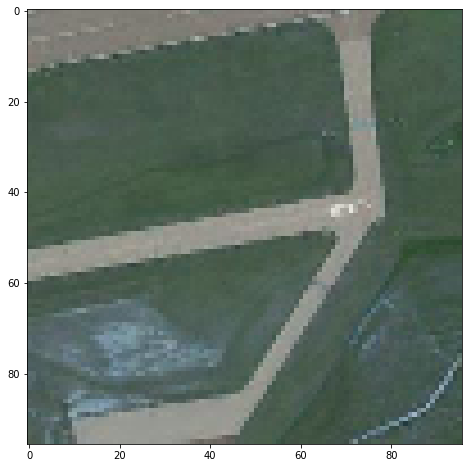

In [10]:
mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

make_example(train_loader=train_loader, classes=classes)

In [11]:
if First_Train: model, MAML_loss_tracker, MAML_val_topks, MAML_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=MAML_learning_rate1, 
                                                                learning_rate1=MAML_learning_rate2, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    MAML_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs=np.load(dir+mtype+'_val_accs.npy')
    epoch_tracker=np.load(dir+'epoch_tracker.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.095
Validation Accuracy:  24.917762756347656
Validation Top3 Accuracy:  48.4375
Epoch 20 - loss: 0.091
Validation Accuracy:  28.3717098236084
Validation Top3 Accuracy:  52.54934310913086
Epoch 30 - loss: 0.087
Validation Accuracy:  35.19736862182617
Validation Top3 Accuracy:  61.019737243652344
Epoch 40 - loss: 0.084
Validation Accuracy:  40.04934310913086
Validation Top3 Accuracy:  68.33881378173828
Epoch 50 - loss: 0.082
Validation Accuracy:  44.57236862182617
Validation Top3 Accuracy:  69.40789794921875
Epoch 60 - loss: 0.079
Validation Accuracy:  47.86184310913086
Validation Top3 Accuracy:  69.98355102539062
Epoch 70 - loss: 0.078
Validation Accuracy:  52.220394134521484
Validation Top3 Accuracy:  74.2598648071289
Epoch 80 - loss: 0.074
Validation Accuracy:  54.11184310913086
Validation Top3 Accuracy:  75.90460205078125
Epoch 90 - loss: 0.073
Validation Accuracy:  54.52302551269531
Validation Top3 Accuracy:  76.48026275634766
Epoch 100 - loss: 0.072
Validation Ac

Test Accuracy:  64.73441314697266
Test Top3 Accuracy:  85.0389633178711


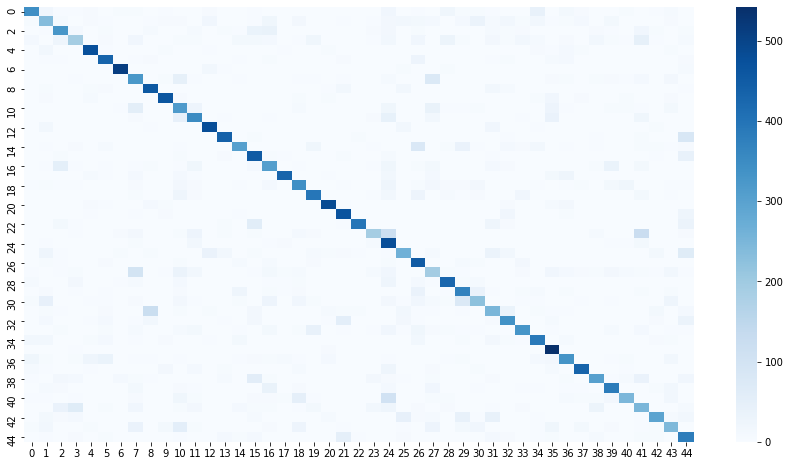

In [12]:
make_test(model=model, testloader=test_loader)

# MAML first order approximation with support for n task batch and inner l2 regularization to compensate for approximation

Require: $p(\mathcal{T}):$ distribution over tasks 

Require: $\alpha, \beta:$ step size hyperparameters

1: randomly initialize $\theta$

2: while not done $\mathbf{d o}$

3: $\quad$ Sample batch of tasks $\mathcal{T}_{i} \sim p(\mathcal{T})$

4: $\quad$ for all $\mathcal{T}_{i}$ do 

5: $\quad$ $\quad$ Evaluate $\nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right)$ with respect to $K$ examples 

6: $\quad$ $\quad$ Compute adapted parameters with gradient descent: $\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right) + ||\theta||_2$

7: $\quad$ end for

8: $\quad$Update $\theta \leftarrow \theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})} \nabla_{\theta_{i}^{\prime}} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}})\right)$

9: end while




tensor(10, dtype=torch.int32) commercial_area


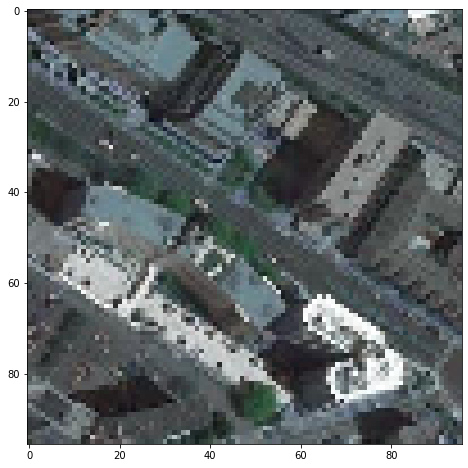

In [13]:
mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

make_example(train_loader=train_loader, classes=classes)
mtype='MAML2'

In [14]:
if First_Train: model, MAML_loss_tracker2, MAML_val_topks2, MAML_val_accs2, epoch_tracker, = train2(n_epochs=n_epochs, 
                                                                learning_rate=MAML2_learning_rate2, 
                                                                learning_rate1=MAML2_learning_rate2, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    MAML_loss_tracker2=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks2=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs2=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.088
Validation Accuracy:  39.0625
Validation Top3 Accuracy:  61.51315689086914
Epoch 20 - loss: 0.079
Validation Accuracy:  45.72368240356445
Validation Top3 Accuracy:  71.71052551269531
Epoch 30 - loss: 0.077
Validation Accuracy:  51.15131759643555
Validation Top3 Accuracy:  74.4243392944336
Epoch 40 - loss: 0.075
Validation Accuracy:  56.99013137817383
Validation Top3 Accuracy:  78.37171173095703
Epoch 50 - loss: 0.072
Validation Accuracy:  61.266448974609375
Validation Top3 Accuracy:  81.66118621826172
Epoch 60 - loss: 0.068
Validation Accuracy:  60.855262756347656
Validation Top3 Accuracy:  83.6348648071289
Epoch 70 - loss: 0.071
Validation Accuracy:  62.08881759643555
Validation Top3 Accuracy:  84.53947448730469
Epoch 80 - loss: 0.063
Validation Accuracy:  65.37828826904297
Validation Top3 Accuracy:  84.45723724365234
Epoch 90 - loss: 0.064
Validation Accuracy:  66.69407653808594
Validation Top3 Accuracy:  84.9506607055664
Epoch 100 - loss: 0.057
Validation Accu

Test Accuracy:  66.98870849609375
Test Top3 Accuracy:  85.84207916259766


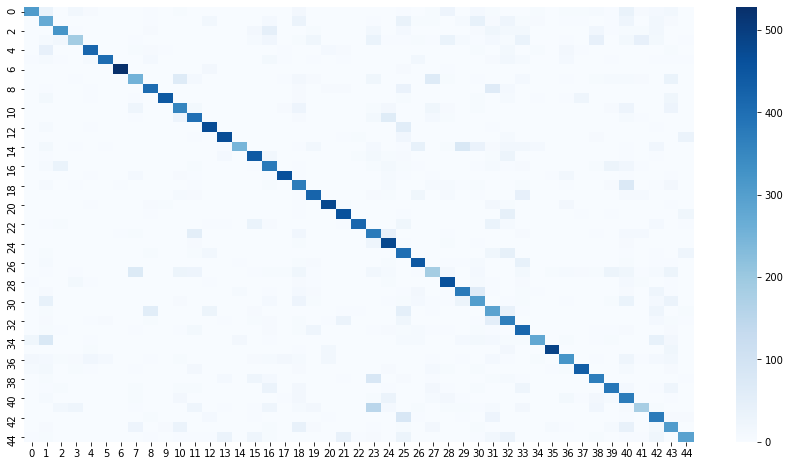

In [15]:
make_test(model=model, testloader=test_loader)

## RESISC CNN with Augs

---

In [16]:
mtype='CNN_Aug'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

if First_Train: model, CNN_Aug_loss_tracker, CNN_Aug_val_topks, CNN_Aug_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=CNN_learning_rate, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    CNN_Aug_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    CNN_Aug_val_topks=np.load(dir+mtype+'_val_topks.npy')
    CNN_Aug_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.088
Validation Accuracy:  33.17307662963867
Validation Top3 Accuracy:  56.971153259277344
Epoch 20 - loss: 0.081
Validation Accuracy:  42.30769348144531
Validation Top3 Accuracy:  66.90705108642578
Epoch 30 - loss: 0.078
Validation Accuracy:  50.32051467895508
Validation Top3 Accuracy:  72.0352554321289
Epoch 40 - loss: 0.074
Validation Accuracy:  54.08654022216797
Validation Top3 Accuracy:  76.04166412353516
Epoch 50 - loss: 0.073
Validation Accuracy:  58.81410217285156
Validation Top3 Accuracy:  80.68910217285156
Epoch 60 - loss: 0.067
Validation Accuracy:  60.65705108642578
Validation Top3 Accuracy:  81.57051086425781
Epoch 70 - loss: 0.067
Validation Accuracy:  64.18269348144531
Validation Top3 Accuracy:  83.97435760498047
Epoch 80 - loss: 0.065
Validation Accuracy:  64.82371520996094
Validation Top3 Accuracy:  85.17628479003906
Epoch 90 - loss: 0.062
Validation Accuracy:  65.70513153076172
Validation Top3 Accuracy:  85.7371826171875
Epoch 100 - loss: 0.067
Valid

Test Accuracy:  70.57655334472656
Test Top3 Accuracy:  88.25047302246094


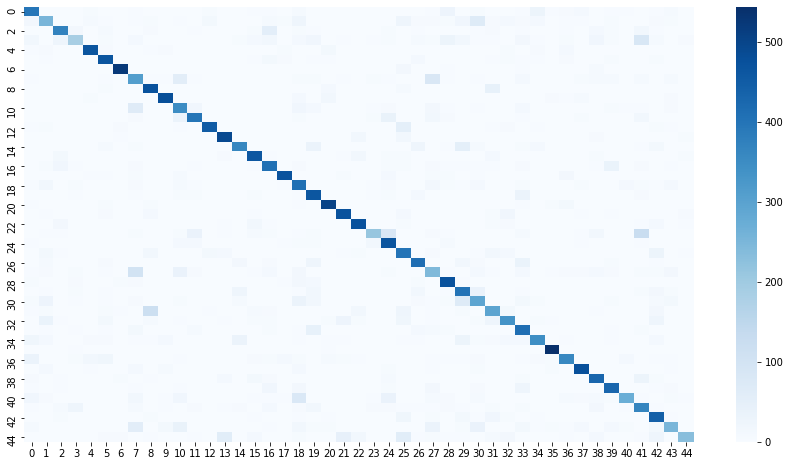

In [17]:
make_test(model=model, testloader=test_loader)

## RESISC CNN no Augs

---

In [18]:
mtype='CNN'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

if First_Train: model, CNN_loss_tracker, CNN_val_topks, CNN_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=CNN_learning_rate, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,
                                                                augs=False,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    CNN_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    CNN_val_topks=np.load(dir+mtype+'_val_topks.npy')
    CNN_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.002
Validation Accuracy:  26.44230842590332
Validation Top3 Accuracy:  44.95192337036133
Epoch 20 - loss: 0.000
Validation Accuracy:  33.97435760498047
Validation Top3 Accuracy:  53.20512771606445
Epoch 30 - loss: 0.000
Validation Accuracy:  35.096153259277344
Validation Top3 Accuracy:  54.40705108642578
Epoch 40 - loss: 0.000
Validation Accuracy:  31.330127716064453
Validation Top3 Accuracy:  53.20512771606445
Epoch 50 - loss: 0.000
Validation Accuracy:  31.730770111083984
Validation Top3 Accuracy:  52.56410217285156
Epoch 60 - loss: 0.000
Validation Accuracy:  28.605770111083984
Validation Top3 Accuracy:  50.480770111083984
Epoch 70 - loss: 0.009
Validation Accuracy:  20.352563858032227
Validation Top3 Accuracy:  40.144229888916016
Epoch 80 - loss: 0.000
Validation Accuracy:  27.644229888916016
Validation Top3 Accuracy:  47.91666793823242
Epoch 90 - loss: 0.000
Validation Accuracy:  29.326923370361328
Validation Top3 Accuracy:  49.519229888916016
Epoch 100 - loss: 

Test Accuracy:  28.11705780029297
Test Top3 Accuracy:  47.430908203125


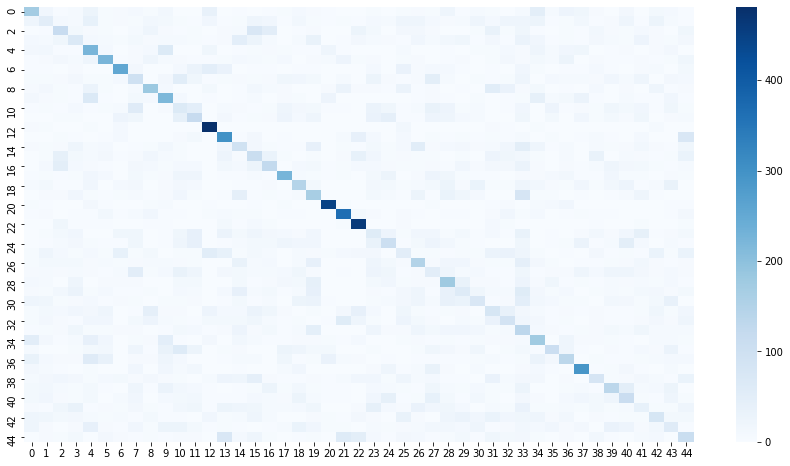

In [19]:
make_test(model=model, testloader=test_loader)

## RESISC CHARTS

---

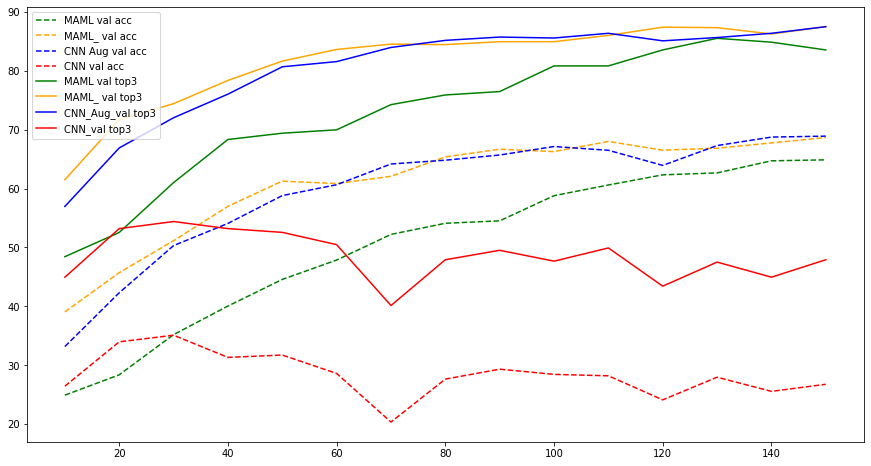

In [20]:
make_train_plot(MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs, MAML_val_topks, CNN_Aug_val_topks, CNN_val_topks, epoch_tracker,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2)

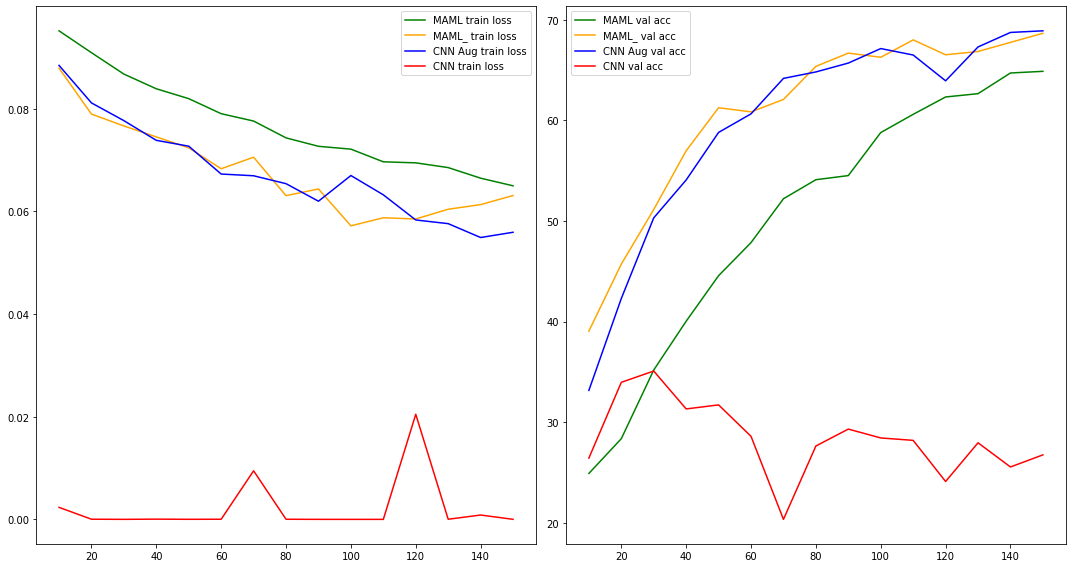

In [21]:
make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2)

## UC MERCED

---

In [22]:
UC_MAML_learning_rate = 0.0006
UC_CNN_learning_rate = 0.0006
UC_epochs = 3
UC_batch_size = 32

UC_data = np.load(dir+'UCMerced_images96.npy')
UC_labels = np.load(dir+'UCMerced_classes.npy')
UC_classes = np.load(dir+'UCMerced_class_names.npy')

UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

UCtrainset = make_dataset(UC_train_data, UC_train_labels)
UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

UCtestset = make_dataset(UC_test_data, UC_test_labels)
UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)

def UC_get_data():
    UC_data = np.load(dir+'UCMerced_images96.npy')
    UC_labels = np.load(dir+'UCMerced_classes.npy')
    UC_classes = np.load(dir+'UCMerced_class_names.npy')

    UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

    UCtrainset = make_dataset(UC_train_data, UC_train_labels)
    UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

    UCtestset = make_dataset(UC_test_data, UC_test_labels)
    UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)
    return UCtrain_loader, UCtest_loader

In [23]:
def UC_train(model, trainloader, epochs=3, lr=0.0006):
    loss_tracker, epoch_tracker = [], []
    #model.load('UC')
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    for epoch in range(1, epochs+1):
        losses = 0
        for X, y in trainloader:
            y = one_hot_embedding(y.to(device), len(UC_classes)).float()
            X = X.float().to(device)
            for param in model.parameters(): param.grad = None
            yhat = model(X)
            pred_loss = bce_loss(yhat, y)
            pred_loss.backward()
            optimizer.step()
            losses += pred_loss.item()
        epoch_tracker.append(epoch)
        loss_tracker.append(losses)
        print(losses)
    return model, epoch_tracker, loss_tracker    

In [24]:
mtype='MAML'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, MAML_loss_tracker = UC_train(model=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2.2918747812509537
1.483506754040718
1.01245940849185


Test Accuracy:  73.19711303710938
Test Top3 Accuracy:  91.64663696289062


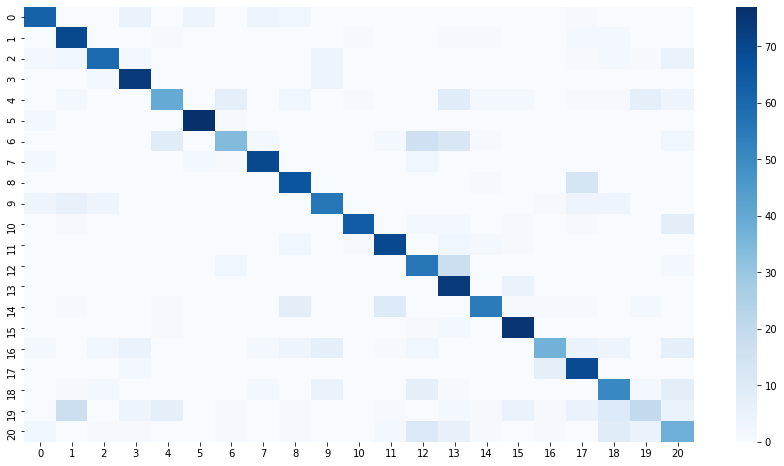

In [25]:
make_test(model=model, testloader=UCtest_loader,get_worse=False)


In [26]:
mtype='MAML2'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, MAML_loss_tracker2 = UC_train(model=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1.9880502447485924
0.7947912625968456
0.419366043061018


Test Accuracy:  73.01683044433594
Test Top3 Accuracy:  91.70673370361328


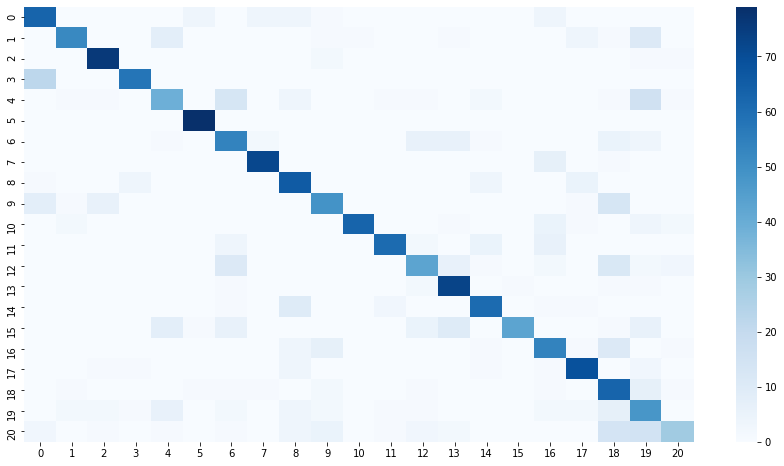

In [27]:
make_test(model=model, testloader=UCtest_loader,get_worse=False)

In [28]:
mtype='CNN'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, CNN_loss_tracker = UC_train(model=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2.528032600879669
1.3337647542357445
0.7215000987052917


Test Accuracy:  46.875
Test Top3 Accuracy:  71.27404022216797


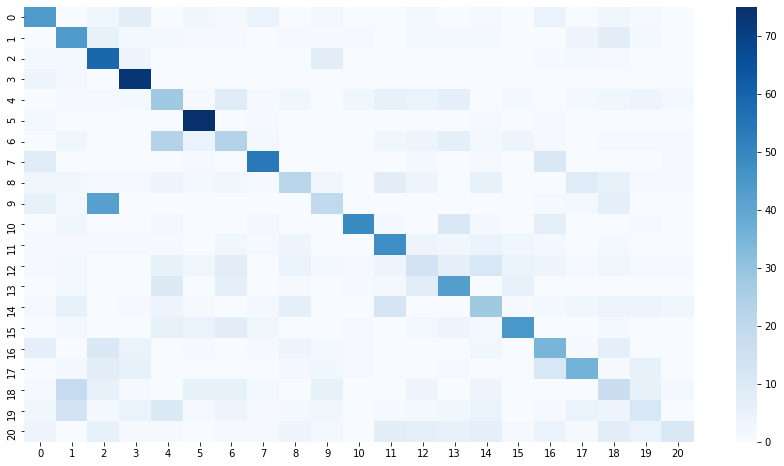

In [29]:
make_test(model=model, testloader=UCtest_loader,get_worse=False)

In [30]:
mtype='CNN_Aug'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, CNN_Aug_loss_tracker = UC_train(model=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2.322173058986664
1.5399117022752762
1.085313681513071


Test Accuracy:  73.13701629638672
Test Top3 Accuracy:  91.70673370361328


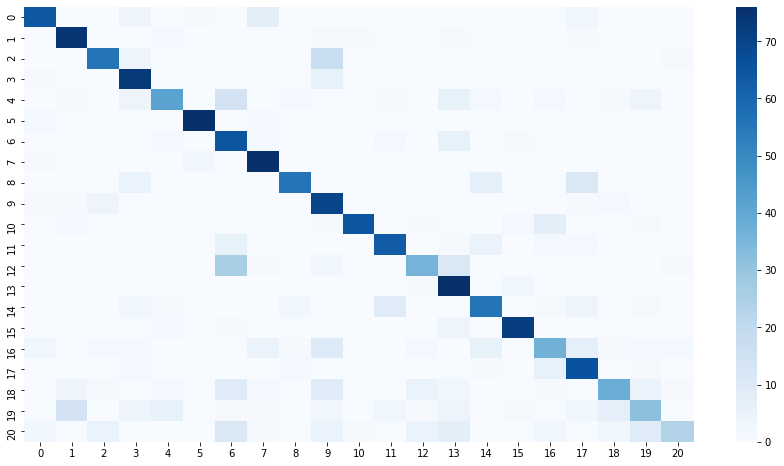

In [31]:
make_test(model=model, testloader=UCtest_loader,get_worse=False)

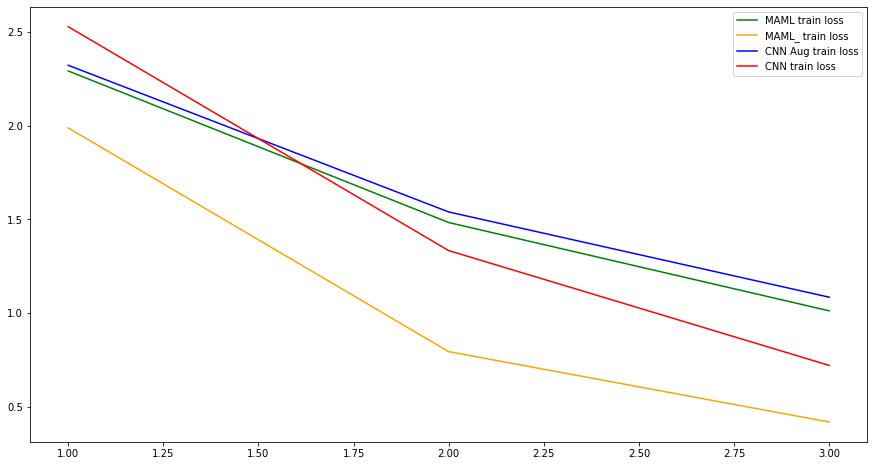

In [32]:
basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker,MAML_loss_tracker2)

## thoughts on UC mercer

To make our results stronger in the code below I trined a fresh CNN,(Should We also do this for other optimization schemes?) on the UC data from scratch with the same params. It is to note that each model gets to about 100 VAL very fast. When looking at the testing data it overfit. I belive this makes our results stronger because we can for sure say some information was passed from the pretraining on RESIC, where it would have otherwise overfit with the same amout of data. It may be worth Rethinking the ratios of testing and training split for UC mercer data as well...

CNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2.3828306198120117
0.9831801801919937
0.3901408649981022
0.14603372430428863
0.11877726507373154
0.045875848503783345
0.03850663744378835
0.018138402490876615
0.01524094701744616
0.010263201897032559
0.008734515402466059
0.029634587655891664
0.03626662740134634
0.050025600008666515
0.025357723236083984
0.02026869243127294
0.011748052944312803
0.007868040833272971
0.006835596388555132
0.0032899345824262127
Test Accuracy:  39.60336685180664
Test Top3 Accuracy:  60.15625
MAML


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.086
Validation Accuracy:  24.038461685180664
Validation Top3 Accuracy:  47.47595977783203
Epoch 20 - loss: 0.079
Validation Accuracy:  29.80769157409668
Validation Top3 Accuracy:  56.91105651855469
saving...
Test Accuracy:  30.048076629638672
Test Top3 Accuracy:  60.15625
MAML2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.072
Validation Accuracy:  38.64182662963867
Validation Top3 Accuracy:  64.66345977783203
Epoch 20 - loss: 0.071
Validation Accuracy:  45.19230651855469
Validation Top3 Accuracy:  72.95673370361328
saving...
Test Accuracy:  46.033653259277344
Test Top3 Accuracy:  74.87980651855469


((('', ''), ('', '')), (('', ''), ('', '')))

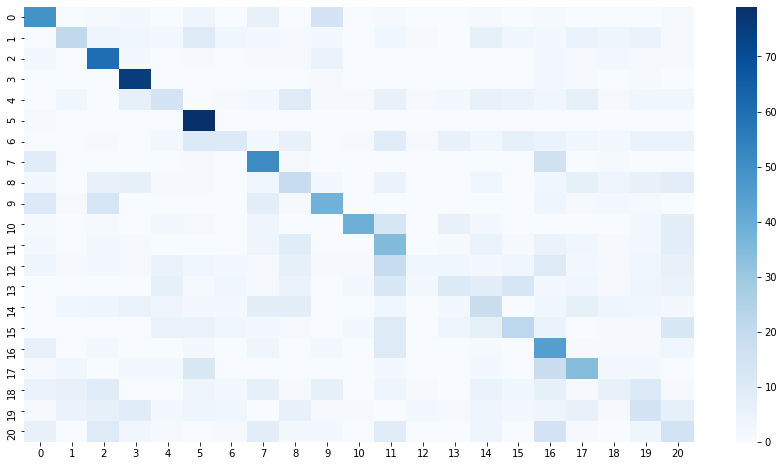

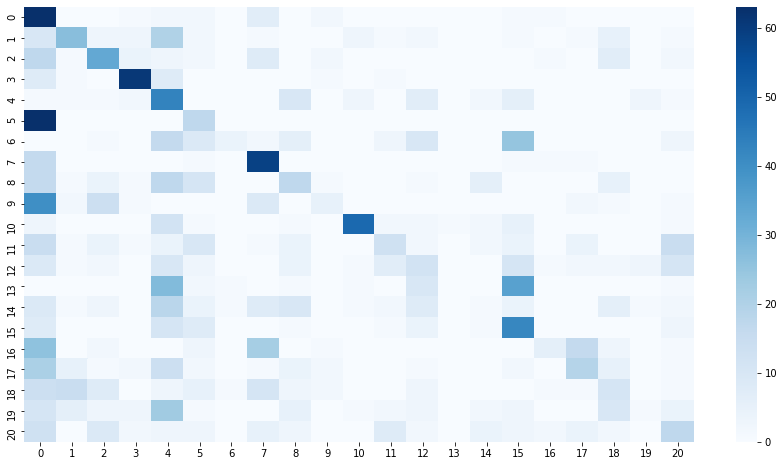

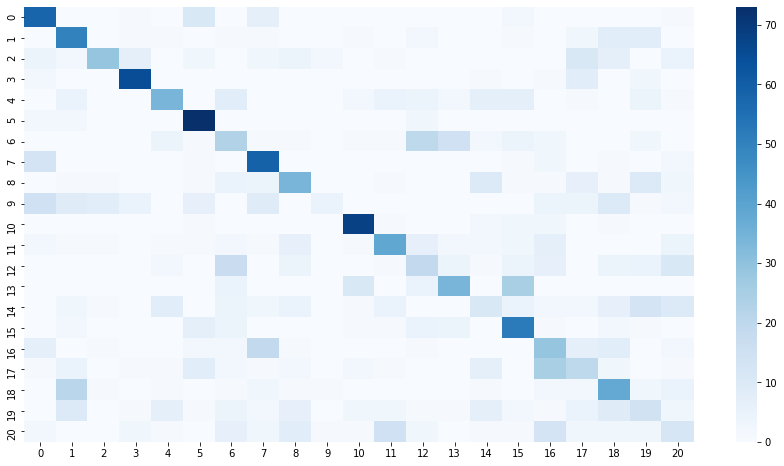

In [38]:
def fresh_train_UC(mtype,load):
    model = get_model(mtype=mtype,load=load)
    UC_MAML_learning_rate = 0.0006
    UC_CNN_learning_rate = 0.0006
    UC_epochs = 20
    UC_batch_size = 32
    UCtrain_loader,UCtest_loader = UC_get_data()
    model.fce = nn.Linear(1024, 21)
    model = model.to(device)
    #model.save('UC'+mtype)
    if mtype == 'CNN':
        print(mtype)
        model, epoch_tracker, CNN_Aug_loss_tracker = UC_train(model=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)
        acc, topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
    elif mtype == "MAML":
        print(mtype)
        model, _, _, _, _=  train(UC_epochs, UC_CNN_learning_rate, UC_CNN_learning_rate, UCtrain_loader, UCtest_loader, c_dim, mtype, augs=True)
        acc, topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)

    elif mtype == 'MAML2':
        print(mtype)
        model, _, _, _, _ =  train2(UC_epochs, UC_CNN_learning_rate, UC_CNN_learning_rate, UCtrain_loader, UCtest_loader, c_dim, mtype)
        acc, topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
    return acc,topk

fresh_train_UC('CNN',load=False)
fresh_train_UC('MAML',load=False)
fresh_train_UC('MAML2',load=False)


    

## Scrap Work Area 

---

In [ ]:
#GRAD DIAGNOSTICS
'''
print("PARAMS YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA == pB).all())
print("GRAD YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA.grad == pB.grad))
'''

In [ ]:
def trainmodel(dir,mtype,n_epochs,learning_rate_1,learning_rate_2):
    train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)
    make_example(train_loader=train_loader, classes=classes)
    if mtype=='CNN' or mtype == "MAML":
        model, loss_tracker, val_topk_tracker, val_acc_tracker, epoch_tracker = train(n_epochs=n_epochs, 
                                                                    learning_rate=learning_rate_1, 
                                                                    learning_rate1=learning_rate_2, 
                                                                    train_loader=train_loader, 
                                                                    val_loader=val_loader, 
                                                                    c_dim=c_dim, 
                                                                    mtype=mtypeprint_stride1=1)
    elif mtype == 'MAML2'
         model, loss_tracker, val_topk_tracker, val_acc_tracker, epoch_tracker = train2(n_epochs=n_epochs, 
                                                                    learning_rate=learning_rate_1, 
                                                                    learning_rate1=learning_rate_2, 
                                                                    train_loader=train_loader, 
                                                                    val_loader=val_loader, 
                                                                    c_dim=c_dim, 
                                                                    mtype=mtype,print_stride1=1)
    return model,test_loader,loss_tracker,val_topk_tracker,val_acc_tracker,epoch_tracker

def AVG_n_model(dir,mtype,n_epochs,learning_rate_1,learning_rate_2,runs=5,UC_or_RES):
    list_loss_tracker,list_val_topk_tracker,list_val_acc_tracker,testacc,testtopk = [],[],[],[],[]
    for _ in range(runs):
        if UC_or_RES=='RES'
            model,test_loader,loss_tracker,val_topk_tracker,val_acc_tracker,epoch_tracker = trainmodel(dir,mtype,n_epochs,learning_rate_1,learning_rate_2)
            list_loss_tracker.append(loss_tracker)
            list_val_topk_tracker.append(val_topk_tracker)
            list_val_acc_tracker.append(val_acc_tracker)

            test_acc, test_topk  = make_test(model,test_loader)
            testacc.append(test_acc)
            testtopk.append(test_topk)
        else:
            testacc1 , testtopk1 = fresh_train_UC(mtype,load=True)
            testacc.append(testacc1)
            testtopk.append(testtopk1)


    avg_loss = numpy.mean(numpy.array(list_loss_tracker), axis=0)
    avg_valtopk = numpy.mean(numpy.array(list_val_topk_tracker), axis=0)
    avg_valacc = numpy.mean(numpy.array(val_acc_tracker), axis=0)
    
    test__valacc = numpy.mean(numpy.array(testacc), axis=0)
    test___valacc = numpy.mean(numpy.array(testtopk), axis=0)

    return avg_loss,avg_valtopk,avg_valacc,test__valacc,test___valacc





    
